INFO       Cache size for target 'cython': 1708 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the 'C:\Users\irtho\.cython\brian_extensions' directory. [brian2]


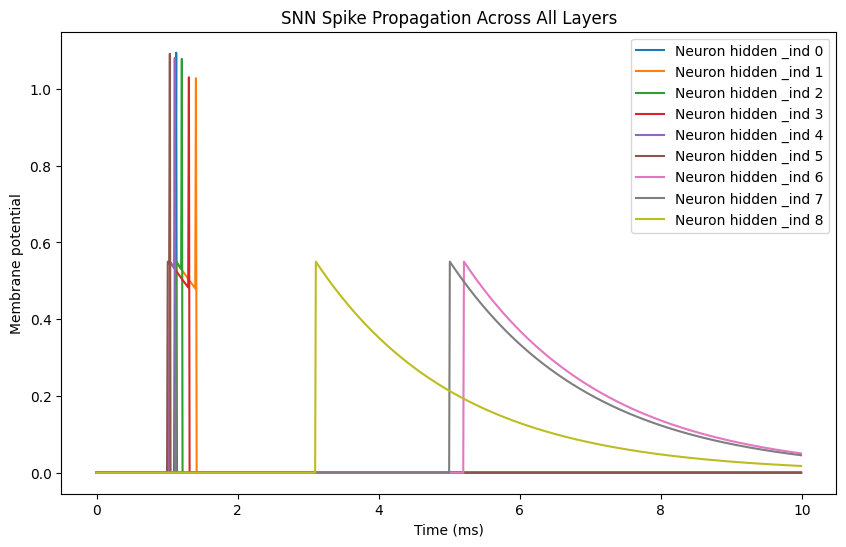

Neuron hidden 0 spike times: ['1.120 ms']
Neuron hidden 1 spike times: ['1.030 ms']
Neuron hidden  idn 0 spike times: ['1.130 ms']
Neuron hidden  idn 1 spike times: ['1.410 ms']
Neuron hidden  idn 2 spike times: ['1.210 ms']
Neuron hidden  idn 3 spike times: ['1.310 ms']
Neuron hidden  idn 4 spike times: ['1.110 ms']
Neuron hidden  idn 5 spike times: ['1.040 ms']
Neuron output  0 spike times: ['1.140 ms', '1.320 ms']
Neuron output  1 spike times: ['1.120 ms', '1.420 ms']
Neuron output  2 spike times: ['1.050 ms', '1.220 ms']


: 

In [ ]:
# v5 Ymir gets X-Y-Z so that 3 layers: 

# v4 : Ymir with varying inputs and outputs x-(x*y)-y network

from brian2 import *
import numpy as np
import logging, warnings

start_scope()

defaultclock.dt = 0.01*ms  

#prefs.codegen.target = 'cython'
set_device('runtime')
warnings.filterwarnings('ignore', category=RuntimeWarning)  # check error later
np.seterr(over='ignore', under='ignore')
logging.getLogger('brian2').setLevel(logging.ERROR)


decay_rate = 2*ms

def run_Ymir(inputs, y, z, taus1, taus2):

    x = len(inputs)
    xy_ind = x*y
    yz_ind = y*z


    if len(taus1) != xy_ind:
        print("not the right size for taus1 buddy")
        raise ValueError(f"Length of taus1 wrong .")
    
    if len(taus2) != yz_ind:
        print("not the right size for taus2 buddy")
        raise ValueError(f"Length of taus2 is wrong")

    input_neurons = NeuronGroup(x,'''
    dv/dt = -v/ decay_rate : volt                 
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    input_neurons.v = 0 * volt

    indices_input = []
    for i in range(0, x):
        indices_input.append(i)

    stim_input = SpikeGeneratorGroup(x, indices=indices_input, times= inputs * ms)

    syn_input = Synapses(stim_input, input_neurons[0:x], '''
    ''', on_pre='''
        v += 1.2 * volt
    ''')
    syn_input.connect(j='i') 

    ind_input_neurons = NeuronGroup(xy_ind,
    '''dv/dt = -v/ decay_rate : volt 
         
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    ind_input_neurons.v = 0 * volt

    input_range = []
    for i in range(0, x):
        for j in range(0, y):
            input_range.append(i)


    ind_input = Synapses(input_neurons[0:x], ind_input_neurons[0:xy_ind], '''
    ''', on_pre='''
        v += 0.55 * volt
    ''')
    ind_input.connect(i=input_range, j=[k for k in range(0, xy_ind)]) # look into what j is later


    stim_tau_hidden = SpikeGeneratorGroup(xy_ind, indices=[k for k in range(0, xy_ind)], times = taus1 * ms)

    syn_tau_hidden = Synapses(stim_tau_hidden, ind_input_neurons[0:xy_ind], '''
    ''', on_pre='''
        v += 0.55 * volt
    ''')
    syn_tau_hidden.connect(j='i')

    hidden_neurons = NeuronGroup(y,
    '''dv/dt = -v/ decay_rate : volt 
         
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    hidden_neurons.v = 0 * volt

    output_range = []
    for i in range(0, x):
        for j in range(0, y):
            output_range.append(j)

    syn_ind_hidden = Synapses(ind_input_neurons[0:xy_ind], hidden_neurons[0:y], '''
    ''', on_pre='''
        v += 1.2 * volt
    ''')

    syn_ind_hidden.connect(i=[k for k in range(0, xy_ind)], j=output_range)

    # last layer copy of above below but changed names same logic -- can functionalize later

    # stim_input = SpikeGeneratorGroup(x, indices=indices_input, times= inputs * ms)

    # syn_input = Synapses(stim_input, input_neurons[0:x], '''
    # ''', on_pre='''
    #     v += 1.2 * volt
    # ''')
    # syn_input.connect(j='i') 

    ind_hidden_neurons = NeuronGroup(yz_ind,
    '''dv/dt = -v/ decay_rate : volt 
         
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    ind_hidden_neurons.v = 0 * volt

    hidden_range = []
    for i in range(0, y):
        for j in range(0, z):
            hidden_range.append(i)


    syn_hidden_output = Synapses(hidden_neurons[0:y], ind_hidden_neurons[0:yz_ind], '''
    ''', on_pre='''
        v += 0.55 * volt
    ''')
    syn_hidden_output.connect(i=hidden_range, j=[k for k in range(0, yz_ind)])


    stim_tau_output = SpikeGeneratorGroup(yz_ind, indices=[k for k in range(0, yz_ind)], times = taus2 * ms)

    syn_tau_output = Synapses(stim_tau_output, ind_hidden_neurons[0:yz_ind], '''
    ''', on_pre='''
        v += 0.55 * volt
    ''')
    syn_tau_output.connect(j='i')

    output_neurons = NeuronGroup(z,
    '''dv/dt = -v/ decay_rate : volt 
         
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    output_neurons.v = 0 * volt

    output_out_range = []
    for i in range(0, y):
        for j in range(0, z):
            output_out_range.append(j)

    syn_output = Synapses(ind_hidden_neurons[0:yz_ind], output_neurons[0:z], '''
    ''', on_pre='''
        v += 1.2 * volt
    ''')

    syn_output.connect(i=[k for k in range(0, yz_ind)], j=output_out_range)

    

























    mon = StateMonitor(input_neurons, 'v', record=True, dt=0.01*ms)
    M1 = StateMonitor(ind_input_neurons, 'v', record=True, dt=0.01*ms)

    M2 = StateMonitor(hidden_neurons, 'v', record=True, dt=0.01*ms)

    M3 = StateMonitor(ind_hidden_neurons, 'v', record=True, dt=0.01*ms)
    M4 = StateMonitor(output_neurons, 'v', record=True, dt=0.01*ms)

    spikemon = SpikeMonitor(input_neurons)
    spikemon_1 = SpikeMonitor(ind_input_neurons)
    spikemon_2 = SpikeMonitor(hidden_neurons)
    spikemon_3 = SpikeMonitor(ind_hidden_neurons)
    spikemon_4 = SpikeMonitor(output_neurons)

    run(10*ms)

    # Plot v
    figure(figsize=(10, 6))
    for i in range(0, yz_ind): 
        #plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
        #plot(M3.t/ms, M2.v[i], label=f'Neuron {i}')
        plot(M3.t/ms, M3.v[i], label=f'Neuron hidden _ind {i}')
    # for i in range(0, z): 
    #     plot(M4.t/ms, M2.v[i], label=f'Neuron output')
    xlabel('Time (ms)')
    ylabel('Membrane potential')
    legend()
    title('SNN Spike Propagation Across All Layers')
    show()

    # for i in range(0,x):
    #     times = spikemon.spike_trains()[i]
    #     if len(times) > 0:
    #         formatted_times = [f"{t/ms:.3f} ms" for t in times]
    #         print(f"Inputs N {i} spike times: {formatted_times}")

    # for i in range(0,xy_ind):
    #     times = spikemon_1.spike_trains()[i]
    #     if len(times) > 0:
    #         formatted_times = [f"{t/ms:.3f} ms" for t in times]
    #         print(f"Neuron input ind {i} spike times: {formatted_times}")

    for i in range(0, y):
        times = spikemon_2.spike_trains()[i]
        if len(times) > 0:
            formatted_times = [f"{t/ms:.3f} ms" for t in times]
            print(f"Neuron hidden {i} spike times: {formatted_times}")

    for i in range(0, yz_ind):
        times = spikemon_3.spike_trains()[i]
        if len(times) > 0:
            formatted_times = [f"{t/ms:.3f} ms" for t in times]
            print(f"Neuron hidden  idn {i} spike times: {formatted_times}")
    
    for i in range(0, z):
        times = spikemon_4.spike_trains()[i]
        if len(times) > 0:
            formatted_times = [f"{t/ms:.3f} ms" for t in times]
            print(f"Neuron output  {i} spike times: {formatted_times}")




inputs = [1.0, 2.0]
y = 3
z = 3

taus1 = [1.1, 1.0, 5.2, 5.0, 1.1, 1.0] # needs to set it so condction is checked before had
taus2 = [1.1, 1.4, 1.2, 1.3, 1.1, 1.0, 5.2, 5.0, 3.1] # needs to set it so condction is checked before had


# x is assumed to be # of inputs
run_Ymir(inputs, y, z, taus1, taus2)





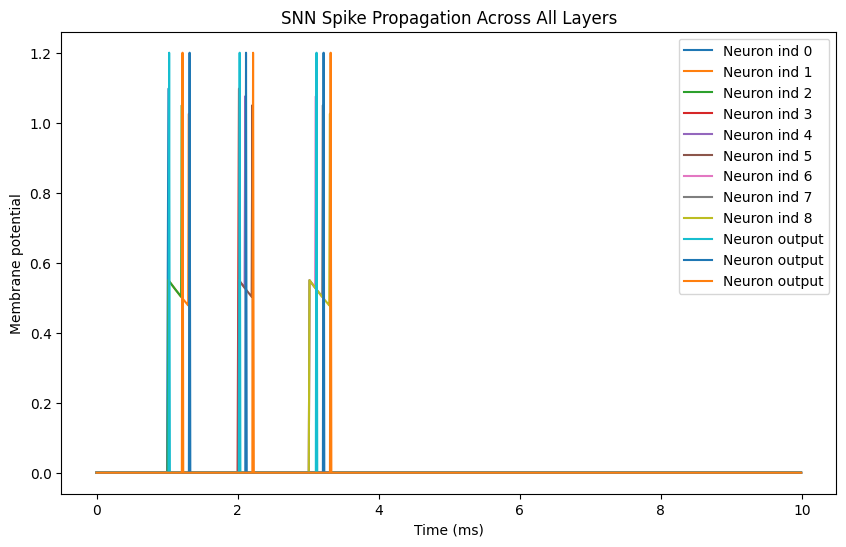

Neuron output 0 spike times: ['1.030 ms', '2.030 ms', '3.120 ms']
Neuron output 1 spike times: ['1.320 ms', '2.120 ms', '3.220 ms']
Neuron output 2 spike times: ['1.220 ms', '2.220 ms', '3.320 ms']


In [60]:
# v4 : Ymir with varying inputs and outputs x-(x*y)-y network

from brian2 import *
import numpy as np
import logging, warnings

start_scope()

defaultclock.dt = 0.01*ms  

#prefs.codegen.target = 'cython'
set_device('runtime')
warnings.filterwarnings('ignore', category=RuntimeWarning)  # check error later
np.seterr(over='ignore', under='ignore')
logging.getLogger('brian2').setLevel(logging.ERROR)


decay_rate = 2*ms

def run_Ymir(inputs, y, taus):


    x = len(inputs)
    ind_val = x*y

    if len(taus) != ind_val:
        raise ValueError(f"Length of taus ({len(taus)}) must match ind_val ({ind_val}).")

    input_neuron = NeuronGroup(x,'''
    dv/dt = -v/ decay_rate : volt                 
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    input_neuron.v = 0 * volt

    indices_input = []
    for i in range(0, x):
        indices_input.append(i)

    stim_input = SpikeGeneratorGroup(x, indices=indices_input, times= inputs * ms)

    syn_input = Synapses(stim_input, input_neuron[0:x], '''
    ''', on_pre='''
        v += 1.2 * volt
    ''')
    syn_input.connect(j='i') 


    
    ind_neuron = NeuronGroup(ind_val,
    '''dv/dt = -v/ decay_rate : volt 
         
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    ind_neuron.v = 0 * volt

    input_range = []
    for i in range(0, x):
        for j in range(0, y):
            input_range.append(i)


    syn_hidden = Synapses(input_neuron[0:x], ind_neuron[0:ind_val], '''
    ''', on_pre='''
        v += 0.55 * volt
    ''')
    syn_hidden.connect(i=input_range, j=[k for k in range(0, ind_val)]) # look into what j is later


    stim_tau_hidden = SpikeGeneratorGroup(ind_val, indices=[k for k in range(0, ind_val)], times = taus * ms)

    syn_tau_hidden = Synapses(stim_tau_hidden, ind_neuron[0:ind_val], '''
    ''', on_pre='''
        v += 0.55 * volt
    ''')
    syn_tau_hidden.connect(j='i')



    out_neuron = NeuronGroup(y,
    '''dv/dt = -v/ decay_rate : volt 
         
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    ind_neuron.v = 0 * volt

    output_range = []
    for i in range(0, x):
        for j in range(0, y):
            output_range.append(j)

    syn_output = Synapses(ind_neuron[0:ind_val], out_neuron[0:y], '''
    ''', on_pre='''
        v += 1.2 * volt
    ''')

    syn_output.connect(i=[k for k in range(0, ind_val)], j=output_range)



    mon = StateMonitor(input_neuron, 'v', record=True, dt=0.01*ms)
    M1 = StateMonitor(ind_neuron, 'v', record=True, dt=0.01*ms)
    M2 = StateMonitor(out_neuron, 'v', record=True, dt=0.01*ms)

    spikemon = SpikeMonitor(input_neuron)
    spikemon_1= SpikeMonitor(ind_neuron)
    spikemon_2 = SpikeMonitor(out_neuron)

    run(10*ms)

    # Plot v
    figure(figsize=(10, 6))
    for i in range(0, ind_val): 
        #plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
        plot(M1.t/ms, M1.v[i], label=f'Neuron ind {i}')
        #plot(M2.t/ms, M2.v[i], label=f'Neuron output')
    for i in range(0, y): 
        plot(M2.t/ms, M2.v[i], label=f'Neuron output')
    xlabel('Time (ms)')
    ylabel('Membrane potential')
    legend()
    title('SNN Spike Propagation Across All Layers')
    show()

    for i in range(0,y):
        times = spikemon_2.spike_trains()[i]
        if len(times) > 0:
            formatted_times = [f"{t/ms:.3f} ms" for t in times]
            print(f"Neuron output {i} spike times: {formatted_times}")



inputs = [1.0, 2.0, 3.0]
taus = [1.0, 1.3, 1.2, 2.0, 2.1, 2.2, 3.1, 3.2, 3.3] # needs to set it so condction is checked before had

y = 3
# x is assumed to be # of inputs
run_Ymir(inputs, y, taus)





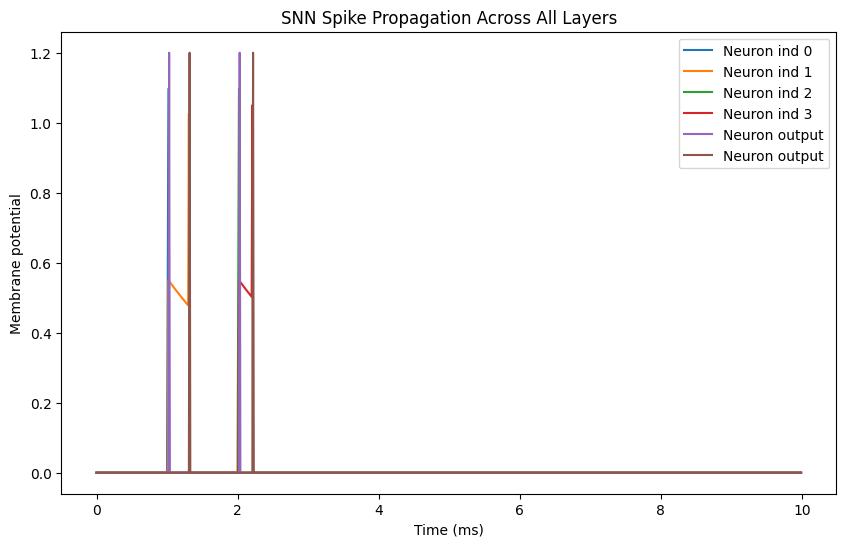

Neuron output 0 spike times: ['1.030 ms', '2.030 ms']
Neuron output 1 spike times: ['1.320 ms', '2.220 ms']


In [ ]:
# v3 : Ymir with 2-(4)-2


from brian2 import *
import numpy as np
import logging, warnings

start_scope()

defaultclock.dt = 0.01*ms  

#prefs.codegen.target = 'cython'
set_device('runtime')
warnings.filterwarnings('ignore', category=RuntimeWarning)  # check error later
np.seterr(over='ignore', under='ignore')
logging.getLogger('brian2').setLevel(logging.ERROR)


decay_rate = 2*ms

def run_Ymir(inputs, taus):

    input_neuron = NeuronGroup(2,'''
    dv/dt = -v/ decay_rate : volt                 
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    input_neuron.v = 0 * volt

    stim_input = SpikeGeneratorGroup(2, indices=[0,1], times= inputs * ms)

    syn_input = Synapses(stim_input, input_neuron[0:2], '''
    ''', on_pre='''
        v += 1.2 * volt
    ''')
    syn_input.connect(j='i') 


    # create an ind_neuron set for each input? 
    ind_neuron = NeuronGroup(4,
    '''dv/dt = -v/ decay_rate : volt 
         
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    ind_neuron.v = 0 * volt


    syn_hidden = Synapses(input_neuron[0:2], ind_neuron[0:4], '''
    ''', on_pre='''
        v += 0.55 * volt
    ''')
    syn_hidden.connect(i=[0, 0, 1, 1], j=[0, 1, 2, 3]) # look into what j is later


    stim_tau_hidden = SpikeGeneratorGroup(4, indices=[0,1,2,3], times = taus * ms)

    syn_tau_hidden = Synapses(stim_tau_hidden, ind_neuron[0:4], '''
    ''', on_pre='''
        v += 0.55 * volt
    ''')
    syn_tau_hidden.connect(j='i')



    out_neuron = NeuronGroup(2,
    '''dv/dt = -v/ decay_rate : volt 
         
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    ind_neuron.v = 0 * volt

    syn_output = Synapses(ind_neuron[0:4], out_neuron[0:2], '''
    ''', on_pre='''
        v += 1.2 * volt
    ''')

    syn_output.connect(i=[0, 1, 2, 3], j=[0, 1, 0, 1])



    mon = StateMonitor(input_neuron, 'v', record=True, dt=0.01*ms)
    M1 = StateMonitor(ind_neuron, 'v', record=True, dt=0.01*ms)
    M2 = StateMonitor(out_neuron, 'v', record=True, dt=0.01*ms)

    spikemon = SpikeMonitor(input_neuron)
    spikemon_1= SpikeMonitor(ind_neuron)
    spikemon_2 = SpikeMonitor(out_neuron)

    run(10*ms)

    # Plot v
    figure(figsize=(10, 6))
    for i in range(0, 4): 
        #plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
        plot(M1.t/ms, M1.v[i], label=f'Neuron ind {i}')
        #plot(M2.t/ms, M2.v[i], label=f'Neuron output')
    for i in range(0, 2): 
        plot(M2.t/ms, M2.v[i], label=f'Neuron output')
    xlabel('Time (ms)')
    ylabel('Membrane potential')
    legend()
    title('SNN Spike Propagation Across All Layers')
    show()

    for i in range(0,2):
        times = spikemon_2.spike_trains()[i]
        if len(times) > 0:
            formatted_times = [f"{t/ms:.3f} ms" for t in times]
            print(f"Neuron output {i} spike times: {formatted_times}")



input = [1.0, 2.0]
taus = [1.0, 1.3, 2.0, 2.2]  # frist two are for input 1 then next two are for input 2

run_Ymir(input, taus)





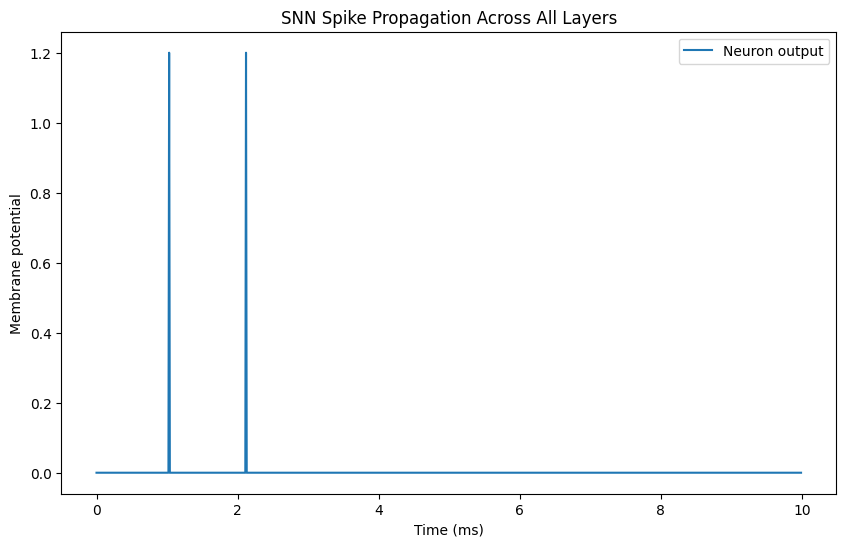

Neuron ind 0 spike times: ['1.030 ms', '2.120 ms']


In [20]:
# v2. ymir 2-1  Neuron with mid neruon 


from brian2 import *
import numpy as np
import logging, warnings

start_scope()

defaultclock.dt = 0.01*ms  

#prefs.codegen.target = 'cython'
set_device('runtime')
warnings.filterwarnings('ignore', category=RuntimeWarning)  # check error later
np.seterr(over='ignore', under='ignore')
logging.getLogger('brian2').setLevel(logging.ERROR)


decay_rate = 2*ms

def run_Ymir(inputs, taus):

    input_neuron = NeuronGroup(2,'''
    dv/dt = -v/ decay_rate : volt                 
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    input_neuron.v = 0 * volt

    stim_input = SpikeGeneratorGroup(2, indices=[0,1], times= inputs * ms)

    syn_input = Synapses(stim_input, input_neuron[0:2], '''
    ''', on_pre='''
        v += 1.2 * volt
    ''')
    syn_input.connect(j='i') 

    ind_neuron = NeuronGroup(2,
    '''dv/dt = -v/ decay_rate : volt 
         
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    ind_neuron.v = 0 * volt


    syn_hidden = Synapses(input_neuron[0:2], ind_neuron[0:2], '''
    ''', on_pre='''
        v += 0.55 * volt
    ''')
    syn_hidden.connect(j='i') 


    stim_tau_hidden = SpikeGeneratorGroup(2, indices=[0,1], times = taus * ms)

    syn_tau_hidden = Synapses(stim_tau_hidden, ind_neuron[0:2], '''
    ''', on_pre='''
        v += 0.55 * volt
    ''')
    syn_tau_hidden.connect(j='i')



    out_neuron = NeuronGroup(1,
    '''dv/dt = -v/ decay_rate : volt 
         
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    ind_neuron.v = 0 * volt

    syn_output = Synapses(ind_neuron[0:2], out_neuron[0], '''
    ''', on_pre='''
        v += 1.2 * volt
    ''')
    syn_output.connect() 



    mon = StateMonitor(input_neuron, 'v', record=True, dt=0.01*ms)
    M1 = StateMonitor(ind_neuron, 'v', record=True, dt=0.01*ms)
    M2 = StateMonitor(out_neuron, 'v', record=True, dt=0.01*ms)

    spikemon = SpikeMonitor(input_neuron)
    spikemon_1= SpikeMonitor(ind_neuron)
    spikemon_2 = SpikeMonitor(out_neuron)

    run(10*ms)

    # Plot v
    figure(figsize=(10, 6))
    for i in range(0, 1): 
        #plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
        #plot(M1.t/ms, M1.v[i], label=f'Neuron ind')
        plot(M2.t/ms, M2.v[i], label=f'Neuron output')
    xlabel('Time (ms)')
    ylabel('Membrane potential')
    legend()
    title('SNN Spike Propagation Across All Layers')
    show()

    for i in range(0,1):
        times = spikemon_2.spike_trains()[i]
        if len(times) > 0:
            formatted_times = [f"{t/ms:.3f} ms" for t in times]
            print(f"Neuron ind {i} spike times: {formatted_times}")



input = [1.0, 2.0]
taus = [0.9, 2.1]  

run_Ymir(input, taus)





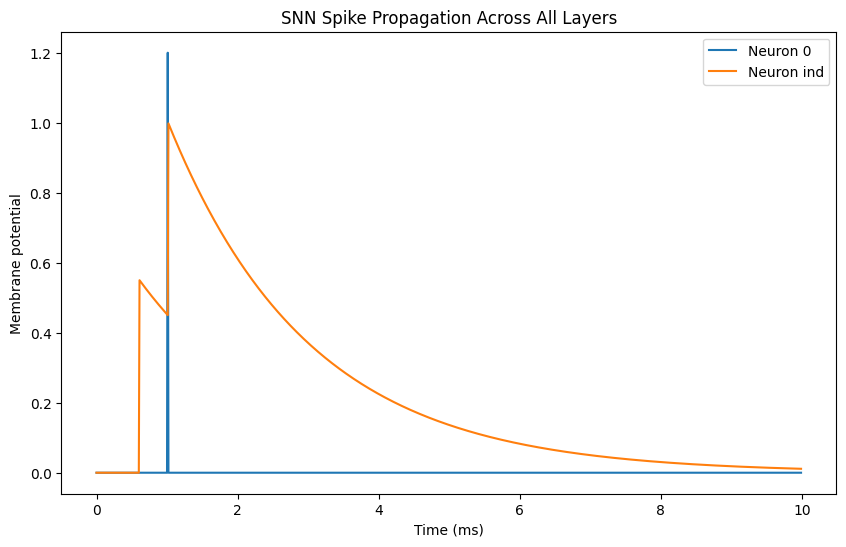

In [ ]:
# v1. ymir 1-1  Neuron with mid neruon 


from brian2 import *
import numpy as np
import logging, warnings

start_scope()

defaultclock.dt = 0.01*ms  

#prefs.codegen.target = 'cython'
set_device('runtime')
warnings.filterwarnings('ignore', category=RuntimeWarning)  # check error later
np.seterr(over='ignore', under='ignore')
logging.getLogger('brian2').setLevel(logging.ERROR)


decay_rate = 2*ms

def run_Ymir(input, tau):

    input_neuron = NeuronGroup(1,'''
    dv/dt = -v/ decay_rate : volt                 
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    input_neuron.v = 0 * volt

    stim_input = SpikeGeneratorGroup(1, indices=[0], times= input * ms)

    syn_input = Synapses(stim_input, input_neuron[0], '''
    ''', on_pre='''
        v += 1.2 * volt
    ''')
    syn_input.connect(j='i') 

    ind_neuron = NeuronGroup(1,
    '''dv/dt = -v/ decay_rate : volt 
         
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    ind_neuron.v = 0 * volt


    syn_hidden = Synapses(input_neuron[0], ind_neuron[0], '''
    ''', on_pre='''
        v += 0.55 * volt
    ''')
    syn_hidden.connect(j='i') 


    stim_tau_hidden = SpikeGeneratorGroup(1, indices=[0], times = tau * ms)

    syn_tau_hidden = Synapses(stim_tau_hidden, ind_neuron[0], '''
    ''', on_pre='''
        v += 0.55 * volt
    ''')
    syn_tau_hidden.connect(j='i')




    mon = StateMonitor(input_neuron, 'v', record=True, dt=0.01*ms)
    M1 = StateMonitor(ind_neuron, 'v', record=True, dt=0.01*ms)
    spikemon = SpikeMonitor(input_neuron)
    spikemon_1= SpikeMonitor(ind_neuron)

    run(10*ms)

    # Plot v
    figure(figsize=(10, 6))
    for i in range(0, 1): 
        plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
        plot(M1.t/ms, M1.v[i], label=f'Neuron ind')
        # plot(M2.t/ms, M2.v2[i], label=f'Neuron {i} v2')
    xlabel('Time (ms)')
    ylabel('Membrane potential')
    legend()
    title('SNN Spike Propagation Across All Layers')
    show()

    for i in range(0,1):
        times = spikemon_1.spike_trains()[i]
        if len(times) > 0:
            formatted_times = [f"{t/ms:.3f} ms" for t in times]
            print(f"Neuron ind spike times: {formatted_times}")



input = [1.0]
tau = [0.6]  # at a value of + .55 voltage and decay of 2ms the range for spieking of .4 in each direction

run_Ymir(input, tau)





In [52]:
list = []
for i in range(0,2):
    for k in range(0,2):
        list.append(k)

print(list)


# print([i for i in range(5)])

[0, 1, 0, 1]
